In [ ]:
#!pip install 'git+https://github.com/facebookresearch/detectron2.git'

--2024-11-07 14:13:55--  http://data.csail.mit.edu/places/ADEchallenge/ADEChallengeData2016.zip
Resolving data.csail.mit.edu (data.csail.mit.edu)... 128.52.131.233
Connecting to data.csail.mit.edu (data.csail.mit.edu)|128.52.131.233|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://data.csail.mit.edu/places/ADEchallenge/ADEChallengeData2016.zip [following]
--2024-11-07 14:13:55--  https://data.csail.mit.edu/places/ADEchallenge/ADEChallengeData2016.zip
Connecting to data.csail.mit.edu (data.csail.mit.edu)|128.52.131.233|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

replace /content/sample_data/ADEChallengeData2016/sceneCategories.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
A
A
A


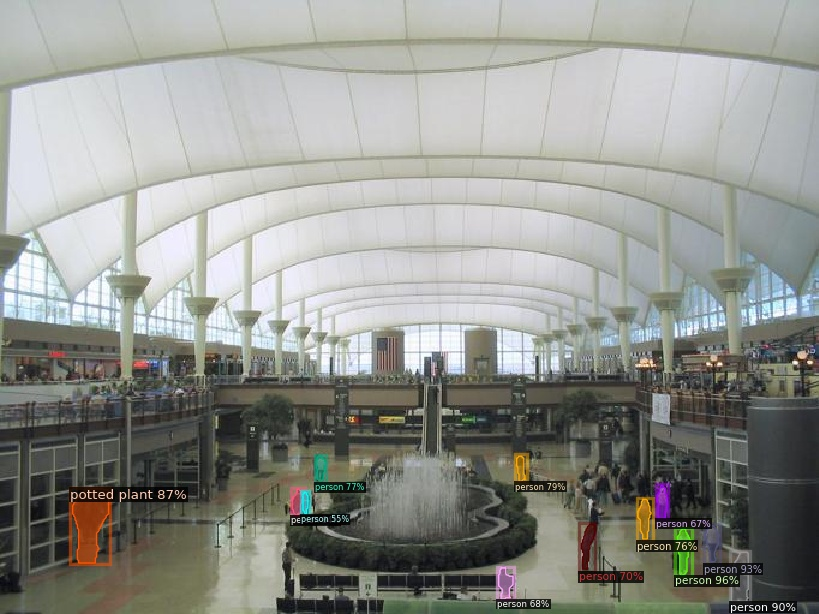

In [5]:
import torch
import torchvision
import cv2
import numpy as np
import os
import detectron2
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from google.colab.patches import cv2_imshow
# Set up the paths and parameters
data_path = "/content/sample_data"
output_path = os.path.join(data_path, "output_images")
os.makedirs(output_path, exist_ok=True)

# Download ADE20K Dataset to /content/sample_data
dataset_zip_path = os.path.join(data_path, "ADEChallengeData2016.zip")
!wget -c http://data.csail.mit.edu/places/ADEchallenge/ADEChallengeData2016.zip -O {dataset_zip_path}
!unzip -qq {dataset_zip_path} -d {data_path}

# Load ADE20K Sample Images from downloaded data
images_path = os.path.join(data_path, "ADEChallengeData2016/images/training/ADE_train_00000001.jpg")

# Load the ADE20K image for testing
image = cv2.imread(images_path)
if image is None:
    raise FileNotFoundError(f"Unable to load image from {images_path}")

# Configure Mask R-CNN with Detectron2 using a pretrained COCO model
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Set threshold for detection
cfg.MODEL.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"  # Use GPU if available

# Initialize the predictor
predictor = DefaultPredictor(cfg)

# Perform prediction using Mask R-CNN
outputs = predictor(image)

# Visualize the results with bounding boxes and masks
v = Visualizer(image[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

# Save the output to /content/sample_data/output_images
output_image_path = os.path.join(output_path, "output_mask_rcnn.jpg")
cv2.imwrite(output_image_path, out.get_image()[:, :, ::-1])

# Display the result using cv2_imshow (for Colab)
output_image = cv2.imread(output_image_path)
cv2_imshow(output_image)  # Use cv2_imshow instead of cv2.imshow
